In [17]:
import qiskit as qt
import qiskit_aer

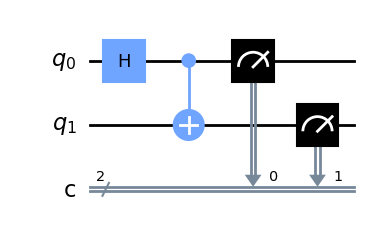

In [2]:
circuit = qt.QuantumCircuit(2, 2)

circuit.h(0)
circuit.cx(0, 1)
circuit.measure([0, 1], [0, 1])

circuit.draw("mpl")

In [3]:
type(circuit)

qiskit.circuit.quantumcircuit.QuantumCircuit

In [4]:
simulator = qiskit_aer.AerSimulator()
compiled_circuit = qt.transpile(circuit, simulator)

In [5]:
type(compiled_circuit)

qiskit.circuit.quantumcircuit.QuantumCircuit

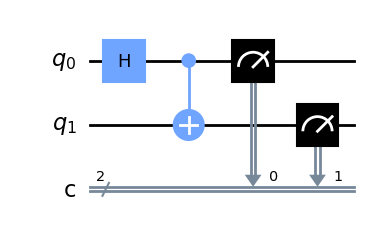

In [6]:
compiled_circuit.draw("mpl")

In [7]:
job = simulator.run(compiled_circuit, shots=1000)

In [8]:
result = job.result()

In [9]:
counts = result.get_counts(compiled_circuit)

In [10]:
print(counts)

{'11': 501, '00': 499}


In [2]:
import dataclasses

@dataclasses.dataclass
class IsingModel:
    quad: dict[tuple[int, int], float]
    linear: dict[int, float]
    constant: float

    def calc_energy(self, state: list[int]) -> float:
        """Calculates the energy of the state."""
        energy = self.constant
        for (i, j), value in self.quad.items():
            energy += value * state[i] * state[j]
        for i, value in self.linear.items():
            energy += value * state[i]
        return energy

def calc_qubo_energy(qubo: dict[tuple[int, int], float], state: list[int]) -> float:
    """Calculates the energy of the state."""
    energy = 0.0
    for (i, j), value in qubo.items():
        energy += value * state[i] * state[j]
    return energy


# def cost_function(qubo: dict[tuple[int, int], float], n_qubit: int) -> qt.QuantumCircuit:
#     """Returns a quantum circuit that represents the QUBO."""
#     ising = qubo_to_ising(qubo, n_qubit)


def qubo_to_ising(
    qubo: dict[tuple[int, int], float]
) -> IsingModel:
    """Converts a QUBO to an Ising model.
    
    QUBO: sum_{ij} Q_{ij} x_i x_j -> Ising: sum_{ij} J_{ij} z_i z_j + sum_i h_i z_i
    Correspondence - x_i = (1 - z_i) / 2, where x_i in {0, 1} and z_i in {-1, 1}
    
    """
    ising_J: dict[tuple[int, int], float] = {}
    ising_h: dict[int, float] = {}
    constant = 0.0
    for (i, j), value in qubo.items():
        if i != j:
            ising_J[(i, j)] = value / 4.0 + ising_J.get((i, j), 0.0)
            constant += value / 4.0
        else:
            constant += value / 2.0
        ising_h[i] = - value / 4.0 + ising_h.get(i, 0.0)
        ising_h[j] = - value / 4.0 + ising_h.get(j, 0.0)
    return IsingModel(ising_J, ising_h, constant)


In [12]:
def cost_operator(qubo: dict[tuple[int, int], float], n_qubit: int) -> qt:

In [23]:
print([p for p in dir(qt) if p[0] != "_"])

['Aer', 'AerWrapper', 'AncillaRegister', 'BasicAer', 'ClassicalRegister', 'IBMQ', 'IBMQWrapper', 'MissingOptionalLibraryError', 'QiskitError', 'QiskitVersion', 'QuantumCircuit', 'QuantumRegister', 'assemble', 'assembler', 'circuit', 'compiler', 'converters', 'dagcircuit', 'exceptions', 'execute', 'execute_function', 'extensions', 'namespace', 'new_meta_path_finder', 'pkgutil', 'providers', 'pulse', 'qasm', 'qiskit', 'qobj', 'quantum_info', 'result', 'schedule', 'scheduler', 'sequence', 'synthesis', 'sys', 'tools', 'transpile', 'transpiler', 'user_config', 'utils', 'version', 'warnings']


In [28]:
qt.quantum_info.operators.Pauli("XX")

Pauli('XX')

In [15]:
ising = qubo_to_ising(qubo)

In [16]:
calc_qubo_energy(qubo, random_binary), ising.calc_energy(random_spin)

(18.744071068124093, 18.744071068124093)

In [ ]:
def qaoa_qubo_cost_operator(qubo: dict[tuple[int, int], float], n_qubit: int) -> qt.QuantumCircuit:
    """Returns a quantum circuit that represents the QUBO."""
    ising = qubo_to_ising(qubo)
    circuit = qt.QuantumCircuit(n_qubit)
    for (i, j), value in ising.quad.items():
        circuit += qt.ZZGate(value) * qt.ZGate(i) * qt.ZGate(j)
    for i, value in ising.linear.items():
        circuit += qt.ZGate(value) * qt.ZGate(i)
    return circuit

In [31]:
P = qt.quantum_info.operators.Pauli('-iXYZ')

print('P[0] =', repr(P[0]))
print('P[1] =', repr(P[1]))
print('P[2] =', repr(P[2]))
print('P[:] =', repr(P[:]))
print('P[::-1] =', repr(P[::-1]))

P[0] = Pauli('Z')
P[1] = Pauli('Y')
P[2] = Pauli('X')
P[:] = Pauli('XYZ')
P[::-1] = Pauli('ZYX')


In [32]:
paulix = qt.quantum_info.operators.Pauli("X")
pauliy = qt.quantum_info.operators.Pauli("Y")

paulix * paulix

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [33]:
qt.opflow

AttributeError: module 'qiskit' has no attribute 'opflow'

In [40]:
xx = qt.quantum_info.operators.Pauli("IIIIXX")
xy = qt.quantum_info.operators.Pauli("IIIIXY")

In [78]:
import numpy as np
import qiskit.quantum_info as qt_ope

def to_ising_operator_from_qubo(qubo: dict[tuple[int, int], float], n_qubit: int) -> qt_ope.SparsePauliOp:
    """Returns a quantum circuit that represents the QUBO."""
    ising = qubo_to_ising(qubo)
    pauli_terms = []

    offset = ising.constant
    zero = np.zeros(n_qubit, dtype=bool)

    # convert linear parts of the objective function into Hamiltonian.
    for idx, coef in ising.linear.items():
        z_p = zero.copy()
        weight = coef
        z_p[idx] = True

        pauli_terms.append(qt_ope.SparsePauliOp(qt_ope.Pauli((z_p, zero)), -weight))
        offset += weight

    # create Pauli terms
    for (i, j), coeff in ising.quad.items():
        weight = coeff

        if i == j:
            offset += weight
        else:
            z_p = zero.copy()
            z_p[i] = True
            z_p[j] = True
            pauli_terms.append(qt_ope.SparsePauliOp(qt_ope.Pauli((z_p, zero)), weight))

        z_p = zero.copy()
        z_p[i] = True
        pauli_terms.append(qt_ope.SparsePauliOp(qt_ope.Pauli((z_p, zero)), -weight))

        z_p = zero.copy()
        z_p[j] = True
        pauli_terms.append(qt_ope.SparsePauliOp(qt_ope.Pauli((z_p, zero)), -weight))

        offset += weight

    if pauli_terms:
        # Remove paulis whose coefficients are zeros.
        qubit_op = sum(pauli_terms).simplify(atol=0)
    else:
        # If there is no variable, we set num_nodes=1 so that qubit_op should be an operator.
        # If num_nodes=0, I^0 = 1 (int).
        num_vars = max(1, num_vars)
        qubit_op = qt_ope.SparsePauliOp("I" * num_vars, 0)

    return qubit_op, offset


In [80]:
ising_H, offset = to_ising_operator_from_qubo({(0, 0): -1, (0, 1): 2}, 2)

AttributeError: module 'qiskit' has no attribute 'algorithms'

In [68]:
xx = qt.quantum_info.operators.SparsePauliOp("IIIIXX")
xy = qt.quantum_info.operators.SparsePauliOp("IIIIXY")

In [69]:
sum(qt.quantum_info.PauliList([xx, xy]))

QiskitError: 'Invalid input data for Pauli.'

In [61]:
import qiskit_optimization as qt_opt

In [63]:
dir(qt_opt)

['INFINITY',
 'QiskitOptimizationError',
 'QuadraticProgram',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'exceptions',
 'infinity',
 'optionals',
 'problems',
 'version']